In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={}

import io
import math
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from IPython.display import Markdown, display, Image
from PIL import Image as PILImage

# LOCAL GIT REPOSITORY LOCATION FOR https://github.com/CSSEGISandData/COVID-19
local_covid_19_data = '/Users/davidmorton/Documents/COVID-19/'

!git -C $local_covid_19_data pull

states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'District of Columbia', 'Northern Mariana Islands', 'Virgin Islands', 'Diamond Princess', 'Grand Princess', 'Recovered']

state_names = pd.read_csv('states.csv').set_index('State').to_dict()['Abbreviation']

Already up to date.


In [2]:
def get_single_date_data(date):
    datestr = date.strftime('%m-%d-%Y')
    filename = local_covid_19_data + 'csse_covid_19_data/csse_covid_19_daily_reports_us/' + datestr + '.csv'
    result = pd.read_csv(filename)
    result['Date'] = date
    return result

def get_daily_report_data():
    start_date_for_daily_data = datetime(2020, 4, 12)
    current_date = start_date_for_daily_data

    yesterday = (datetime.now() + timedelta(days = -1))
    #yesterday = datetime.now()
    lastdate = yesterday.strftime('%m-%d-%Y')
    
    series = pd.DataFrame()

    while True:
        series = series.append(get_single_date_data(current_date))
        current_date = current_date + timedelta(days = 1)
        if current_date > yesterday:
            break
    
    
    return series

def get_covid_percentages():
    states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'Northern Mariana Islands', 'Virgin Islands', 'Diamond Princess', 'Grand Princess', 'Recovered']

    # Get the daily report, and immediately sort it by province and date, and remove the non-state territories. 
    data = get_daily_report_data()[['Province_State', 'Date', 'Confirmed', 'People_Tested']]
    data = data.sort_values(by=['Province_State', 'Date']).reset_index()
    data = data[~data['Province_State'].isin(states_to_drop)]
    data = data.set_index(['Province_State', 'Date'])
    
    # Create a confirmed percentage column, and then roll it in a 7-day rolling average
    data['ConfirmedPercent'] = data['Confirmed'].div(data['People_Tested'])
    data['ConfirmedPercentRolling'] = data.sort_values(by=['Province_State', 'Date']).groupby('Province_State')['ConfirmedPercent'].rolling(window=7).mean().reset_index(level=1, drop=1)

    # Create a pivot table for use in the heatmap.
    data = data.reset_index()[['Province_State', 'Date', 'ConfirmedPercentRolling']].pivot(values='ConfirmedPercentRolling', index='Date', columns='Province_State')
    data = data.reindex(data.mean().sort_values(ascending=False).index, axis=1).dropna()

    return data

In [6]:
def get_cdc_raw_data():
    return pd.read_csv('https://data.cdc.gov/api/views/u6jv-9ijr/rows.csv?accessType=DOWNLOAD&bom=true&format=true%20target=')
    
def get_excess_deaths(rawdata):
    rawdata = rawdata[rawdata['Jurisdiction'] != 'United States']
    gte2020 = rawdata[rawdata['Year'] == 2020].groupby(['Jurisdiction', 'Week'])[['Number of Deaths']].sum()
    maxweek = gte2020.reset_index()['Week'].max()
    lt2020 = rawdata[(rawdata['Year'] < 2020) & (rawdata['Week'] <= maxweek)].groupby(['Jurisdiction', 'Year', 'Week']).sum()[['Number of Deaths']].groupby(['Jurisdiction', 'Week']).mean()#.rename(columns={'Number of Deaths': 'Avg'})

    compareData = lt2020.copy().rename(columns={'Number of Deaths':'Average'})

    compareData['2020'] = gte2020['Number of Deaths']

    compareData = compareData.fillna(0)

    compareData['Difference'] = (compareData['2020'].div(compareData['Average']) * 100) - 100

    compareData = compareData.reset_index()

    pivottable = compareData.pivot(index='Week', columns='Jurisdiction', values='Difference')

    pivottable['Week Ending'] = pd.to_datetime(rawdata[rawdata['Year'] == 2020].groupby(['Week'])['Week Ending Date'].max())
    pivottable = pivottable.reset_index().set_index('Week Ending').drop(['Week'], axis=1)
    pivottable['New York'] = pivottable['New York'] + pivottable['New York City']
    pivottable = pivottable.drop(['New York City', 'Puerto Rico'], axis=1)
    return pivottable

In [7]:
cdc_data = get_cdc_raw_data()
excess_deaths = get_excess_deaths(cdc_data)

In [49]:
df = cdc_data.copy()
df.Jurisdiction = df[df.Jurisdiction != 'United States']
df = df[['Week Ending Date', 'Number of Deaths']].rename(columns={'Week Ending Date':'week', 'Number of Deaths':'deaths'})
df.week = df.week.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df = df.groupby('week').sum()
df
df['year'] = df.apply(lambda x:x.index.year)


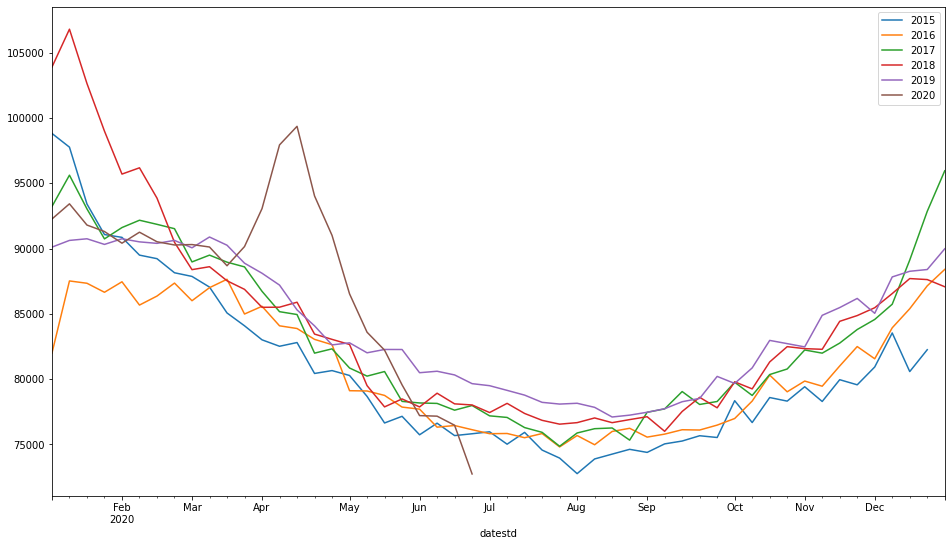

In [80]:
df2 = pd.DataFrame([df[df.year == i].deaths.tolist() for i in range(2015,2021)], index=[i for i in range(2015,2021)]).T[0:-1]
df2['datestd'] = [datetime(2020, 1, 1) + timedelta(days=(i+1)*7) for i in df2.index.tolist()]
df2 = df2.set_index('datestd')
df2.plot.line(figsize=(16,9))
#df.deaths.plot.line(ylim=(0,110000), figsize=(16,9))
#df.sort_values(by='week').set_index('week')


In [81]:
cdc_data

,Jurisdiction,Week Ending Date,State Abbreviation,Year,Week,Cause Group,Number of Deaths,Cause Subgroup,Time Period,Suppress,Note,Average Number of Deaths in Time Period,Difference from 2015-2019 to 2020,Percent Difference from 2015-2019 to 2020,Type
0,Alabama,2015-01-10,AL,2015,1,Alzheimer disease and dementia,120.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
1,Alabama,2016-01-09,AL,2016,1,Alzheimer disease and dementia,76.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
2,Alabama,2017-01-07,AL,2017,1,Alzheimer disease and dementia,96.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
3,Alabama,2018-01-06,AL,2018,1,Alzheimer disease and dementia,108.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
4,Alabama,2019-01-05,AL,2019,1,Alzheimer disease and dementia,115.0,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150371,Wisconsin,2016-01-02,WI,2015,52,Other diseases of the respiratory system,23.0,Respiratory diseases,2015-2019,NaN,NaN,25,NaN,NaN,Predicted (weighted)
150372,Wisconsin,2016-12-31,WI,2016,52,Other diseases of the respiratory system,30.0,Respiratory diseases,2015-2019,NaN,NaN,25,NaN,NaN,Predicted (weighted)
150373,Wisconsin,2017-12-30,WI,2017,52,Other diseases of the respiratory system,20.0,Respiratory diseases,2015-2019,NaN,NaN,25,NaN,NaN,Predicted (weighted)
150374,Wisconsin,2018-12-29,WI,2018,52,Other diseases of the respiratory system,27.0,Respiratory diseases,2015-2019,NaN,NaN,25,NaN,NaN,Predicted (weighted)


In [74]:
df2.set_index('datestd')

,0,1,2,3,4,5,datestd
0,98810.0,81993.0,93216.0,103889.0,90106.0,92259.0,2020-01-08
1,97760.0,87517.0,95615.0,106790.0,90620.0,93420.0,2020-01-15
2,93408.0,87340.0,93032.0,102632.0,90745.0,91796.0,2020-01-22
3,91069.0,86650.0,90737.0,98987.0,90314.0,91302.0,2020-01-29
4,90853.0,87453.0,91604.0,95698.0,90746.0,90408.0,2020-02-05
5,89494.0,85670.0,92165.0,96178.0,90509.0,91249.0,2020-02-12
6,89222.0,86359.0,91851.0,93858.0,90395.0,90517.0,2020-02-19
7,88144.0,87353.0,91518.0,90474.0,90621.0,90271.0,2020-02-26
8,87863.0,86003.0,88973.0,88382.0,90054.0,90303.0,2020-03-04
9,87047.0,87002.0,89493.0,88607.0,90881.0,90115.0,2020-03-11
